In [2]:
import xarray as xr
import gcsfs
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import time
from matplotlib.colors import LogNorm
from IPython.display import clear_output
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from intake import open_catalog

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

import pandas as pd



In [3]:
plt.rcParams.update({'font.size': 14
    , 'legend.markerscale': 1., 'axes.titlesize': 14, 'axes.labelsize' : 12,
      'legend.fontsize' : 13,'legend.handlelength': 3})

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'
# plt.rcParams['figure.figsize'] = (14.,5.)



blue = cm.get_cmap('Blues', 256)
green = cm.get_cmap('Greens', 256)
red = cm.get_cmap('Reds', 256)
grey = cm.get_cmap('Greys', 256)
bone = cm.get_cmap('bone_r', 256)
binary = cm.get_cmap('binary', 256)
hot = cm.get_cmap('hot_r', 256)
gray = cm.get_cmap('gray_r', 256)


newcolors5 = blue(np.linspace(0, 1, 256))**2*grey(np.linspace(0, 1, 256))**0.2
newcmp5 = ListedColormap(newcolors5[::-1], name='BlueGrey')

newcolors7 = blue(np.linspace(0, 1, 256))**1.5*green(np.linspace(0, 1, 256))**0.3*grey(np.linspace(0, 1, 256))**0.03
newcmp7 = ListedColormap(newcolors7[::-1], name='BluegreenGrey')

newcmp6 = ListedColormap(newcolors5, name='BlueGrey_r')
newcmp8 = ListedColormap(newcolors7, name='BlueGreenGrey_r')

def plot_examples(cms):
    """
    helper function to plot two colormaps
    """
    np.random.seed(19680801)
    data = np.random.randn(30, 30)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
    for [ax, cmap] in zip(axs, cms):
        psm = ax.pcolormesh(data, cmap=cmap, rasterized=True, vmin=-4, vmax=4)
        fig.colorbar(psm, ax=ax)
    plt.show()

In [4]:
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml")
ds  = cat["CESM_POP_hires_control"].to_dask()
# ds

In [5]:
ds = ds.rename({'U1_1':'U', 'V1_1':'V', 'TAUX_2':'TAUX', 'TAUY_2':'TAUY', 'SSH_2':'SSH', 'ULONG':'XU', 'ULAT':'YU'})

def make_3d_coords(lon,lat):
    X = np.sin(np.radians(lat))
    Y = np.sin(np.radians(lon))*np.cos(np.radians(lat))
    Z = -np.cos(np.radians(lon))*np.cos(np.radians(lat))
    return (X,Y,Z)

X, Y, Z = make_3d_coords(ds.XU.data, ds.YU.data)

ds['X'] = ds.XU.dims, X
ds['Y'] = ds.XU.dims, Y
ds['Z'] = ds.XU.dims, Z

def normalize_gridspacing(DX,DY):
    dX = (DX - np.mean(DX))/np.std(DX)
    dY = (DY - np.mean(DY))/np.std(DY)
    
    return (dX, dY)

dX, dY = normalize_gridspacing(ds.DXT.data, ds.DYT.data)

ds['dx'] = ds.XU.dims, dX
ds['dy'] = ds.XU.dims, dY

ds

<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 14965, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HT                  (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HTE                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HTN                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HU                  (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HUS                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    HUW                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    KMU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    REGION_MASK         (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    T0_Kelvin           float64 ...
    TAREA               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT                (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLONG               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    UAREA               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    YU                  (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    XU                  (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    cp_air              float64 ...
    cp_sw               float64 ...
    days_in_norm_year   timedelta64[ns] ...
    dz                  (z_t) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    dzw                 (z_w) float32 dask.array<chunksize=(62,), meta=np.ndarray>
    fwflux_factor       float64 ...
    grav                float64 ...
    heat_to_PW          float64 ...
    hflux_factor        float64 ...
    latent_heat_fusion  float64 ...
    latent_heat_vapor   float64 ...
    mass_to_Sv          float64 ...
    momentum_factor     float64 ...
    nsurface_t          float64 ...
    nsurface_u          float64 ...
    ocn_ref_salinity    float64 ...
    omega               float64 ...
    ppt_to_salt         float64 ...
    radius              float64 ...
    rho_air             float64 ...
    rho_fw              float64 ...
    rho_sw              float64 ...
    salinity_factor     float64 ...
    salt_to_Svppt       float64 ...
    salt_to_mmday       float64 ...
    salt_to_ppt         float64 ...
    sea_ice_salinity    float64 ...
    sflux_factor        float64 ...
    sound               float64 ...
    stefan_boltzmann    float64 ...
  * time                (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:0...
    vonkar              float64 ...
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    HMXL_2              (time, 

In [6]:
def reshape_stencil(data, ssize):
    assert data.ndim == 2
    ny, nx = data.shape
    data_rs = data.reshape((ny//ssize, ssize,  nx//ssize, ssize))
    # move stencil to end
    data_mv = np.moveaxis(data_rs, 1, 2)
    data_flat = data_mv.reshape((-1, 2, 2))
    return data_flat

def extract_data(ds, vname, stencil_size, indexer):
    data = ds[vname].values
    data_rs = reshape_stencil(data, stencil_size)
    data_idx = data_rs[(slice(None),) + indexer]
    return data_idx

In [7]:
stencil_size = 2

def prepare_data_2D(ds, apply_mask=True, randomize=True,
                 stencil_vars = ['SSH', 'SST', 'X', 'Y', 'Z'], stencil_index = (slice(None), slice(None)),
                 point_vars = ['TAUX', 'TAUY'], point_index = (0, 0), 
                 target_vars = ['U', 'V'], target_index = (0, 0) ):
    
    stencil_data = [extract_data(ds, vname, stencil_size, stencil_index)
                    for vname in stencil_vars]
    point_data = [extract_data(ds, vname, stencil_size, point_index)
                   for vname in point_vars]
    target_data = [extract_data(ds, vname, stencil_size, target_index)
                   for vname in target_vars]

    if apply_mask:
        mask = np.isnan(stencil_data[0]).sum(axis=(1, 2)) == 0
    else:
        mask = slice(None)
    if randomize:
        random_idx = np.random.permutation(mask.sum())
    else:
        random_idx = slice(None)

    features_stencil = np.stack([data[mask][random_idx] for data in stencil_data],
                                axis=-1)
    features_point = np.stack([data[mask][random_idx] for data in point_data],
                               axis=-1)
    targets = np.stack([data[mask][random_idx] for data in target_data],
                        axis=-1)
    
    return [features_stencil, features_point], targets

In [8]:
inputs = {}
targets = {}


In [9]:
inputs['00'], targets['00'] = prepare_data_2D(ds.isel(time=10), stencil_vars = ['SSH',], point_vars=['TAUX','TAUY',])
inputs['01'], targets['01'] = prepare_data_2D(ds.isel(time=10), stencil_vars = ['SSH',], point_vars=['X',])
inputs['02'], targets['02'] = prepare_data_2D(ds.isel(time=10), stencil_vars = ['SSH','SST',], point_vars=['X',])
inputs['03'], targets['03'] = prepare_data_2D(ds.isel(time=10), stencil_vars = ['SSH',], point_vars=['X','TAUX','TAUY',])
inputs['04'], targets['04'] = prepare_data_2D(ds.isel(time=10), stencil_vars = ['SSH','SST',], point_vars=['X','TAUX','TAUY'])


In [22]:
input_stencil = {}
input_points = {}
conv_layer = {}
reshape_layer = {}
concat_layer = {}
combined_relu = {}
hidden_layer_1 = {}
hidden_layer_2 = {}
hidden_layer_3 = {}
output_layer = {}
model = {}

nfilters = 80

for r in inputs.keys():
    input_stencil[r] = keras.Input(shape=inputs[r][0].shape[1:])
    input_points[r] = keras.Input(shape=inputs[r][1].shape[1:])
    conv_layer[r] = tf.keras.layers.Conv2D(nfilters, 2)(input_stencil[r])
    reshape_layer[r] = tf.keras.layers.Reshape((nfilters,))(conv_layer[r])
    concat_layer[r] = tf.keras.layers.concatenate([reshape_layer[r], input_points[r]])
    combined_relu[r] = tf.keras.layers.LeakyReLU(alpha=0.3)(concat_layer[r])
    hidden_layer_1[r] = tf.keras.layers.Dense(40, activation='relu')(combined_relu[r])
    hidden_layer_2[r] = tf.keras.layers.Dense(20, activation='relu')(hidden_layer_1[r])
    hidden_layer_3[r] = tf.keras.layers.Dense(10, activation='relu')(hidden_layer_2[r])
    output_layer[r] = tf.keras.layers.Dense(2)(hidden_layer_3[r])

    model[r] = tf.keras.Model(inputs=[input_stencil[r], input_points[r]],
                        outputs=output_layer[r])

    # optimizer = tf.train.AdamOptimizer()
    model[r].compile(loss='mae', optimizer='Adam', metrics=['mae', 'mse','accuracy'])
    model[r].summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 2, 2, 1)]    0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 1, 1, 80)     400         input_25[0][0]                   
__________________________________________________________________________________________________
reshape_12 (Reshape)            (None, 80)           0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
input_26 (InputLayer)           [(None, 2)]          0                                            
___________________________________________________________________________________________

In [19]:
labels = {}

labels['00'] = 'SSH_2ps_pointTAUXTAUY_3l_402010_nf80'
labels['01'] = 'SSH_2ps_pointX_3l_402010_nf80'
labels['02'] = 'SSHSST_2ps_pointX_3l_402010_nf80'
labels['03'] = 'SSH_2ps_pointXTAUXTAUY_3l_402010_nf80'
labels['04'] = 'SSHSST_2ps_pointXTAUXTAUY_3l_402010_nf80'


In [23]:
# this will help save training history more frequently
# https://keras.io/callbacks/#create-a-callback

class LossHistory(keras.callbacks.Callback):
    def __init__(self, frequency=100):
        self.frequency = frequency
        self.batch_counter = 0
        self.losses = []
        
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.mse = []
        self.accuracy = []
        
        self.fig = plt.figure()
        
        self.logs = []
        
    def on_batch_end(self, batch, logs={}):
        if batch % self.frequency == 0:
            self.batch_counter += self.frequency
            self.logs.append(logs)
            self.x.append(self.i)
            self.losses.append(logs.get('loss'))
            self.mse.append(logs.get('mse'))
            self.accuracy.append(logs.get('accuracy'))
        
            self.i += 1
        
            clear_output(wait=True)
            plt.figure(figsize=(18,5))
            plt.subplot(131)
            plt.plot(self.x, self.losses,color=color1,label="loss")
            plt.plot(self.x[-1], self.losses[-1],marker = 'o', markersize=10, color=color1)
            plt.legend()
            plt.xlabel(r'batch');
            plt.ylabel('Mean Absolute Error');
            plt.ylim([2,12])
            plt.subplot(132)
            plt.plot(self.x, self.mse, color=color2)
            plt.plot(self.x[-1], self.mse[-1],marker = 'o', markersize=10, color=color2)
            plt.xlabel('batch');
            plt.ylabel(r'Mean Squared Error [$cm^2/s^2$]');
            plt.ylim([10,330])

            plt.subplot(133)
            plt.plot(self.x, self.accuracy, color=color3)
            plt.plot(self.x[-1], self.accuracy[-1],marker = 'o', markersize=10, color=color3)
            plt.xlabel('batch');
            plt.ylabel('Model Accuracy');
            plt.ylim([0.1,0.95])

            plt.show();

In [24]:
history = {}

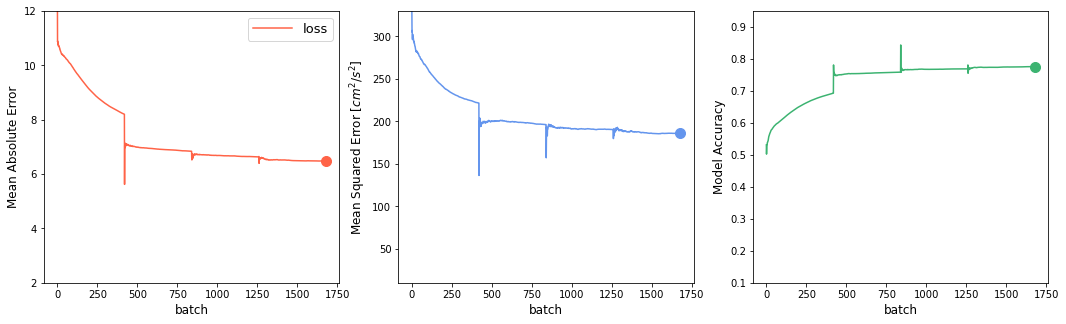

41967/41967 [==============================] - 281s 7ms/step - loss: 6.4800 - mae: 6.4800 - mse: 185.7966 - accuracy: 0.7761
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/SSH_2ps_pointTAUXTAUY_3l_402010_nf80/assets


In [25]:
mnum = '00'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


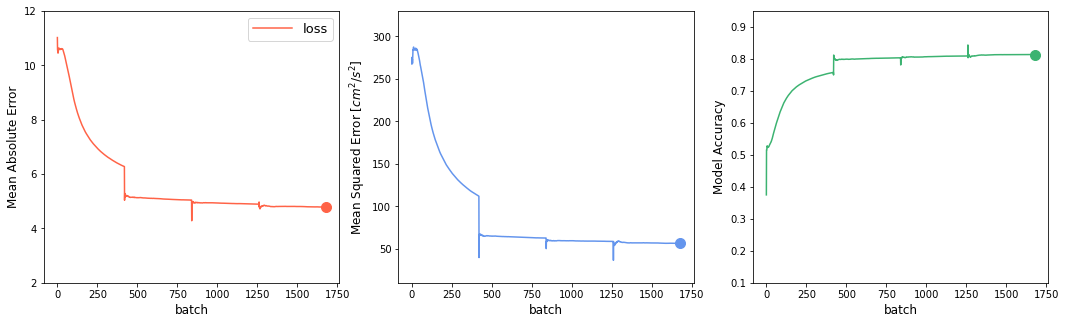

41967/41967 [==============================] - 277s 7ms/step - loss: 4.7862 - mae: 4.7862 - mse: 56.3971 - accuracy: 0.8139
INFO:tensorflow:Assets written to: models/SSH_2ps_pointX_3l_402010_nf80/assets


In [26]:
mnum = '01'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


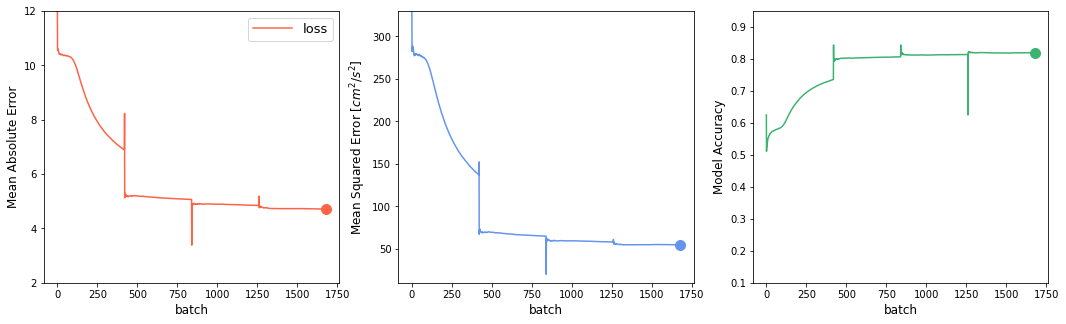

41967/41967 [==============================] - 277s 7ms/step - loss: 4.7123 - mae: 4.7123 - mse: 54.7725 - accuracy: 0.8192
INFO:tensorflow:Assets written to: models/SSHSST_2ps_pointX_3l_402010_nf80/assets


In [27]:
mnum = '02'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


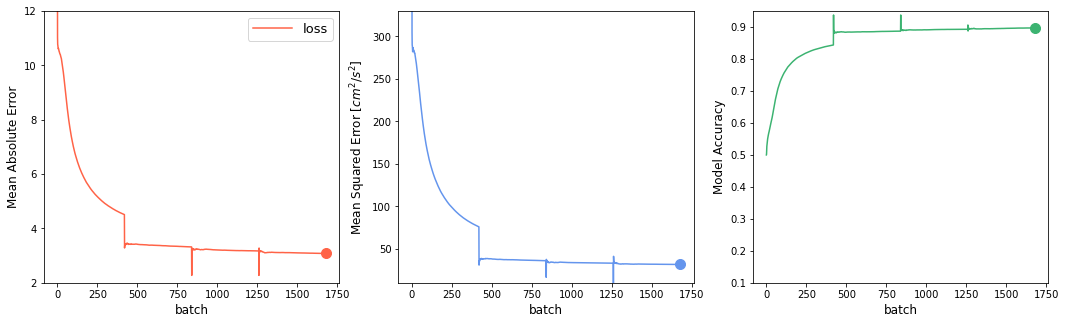

41967/41967 [==============================] - 289s 7ms/step - loss: 3.0785 - mae: 3.0785 - mse: 31.5865 - accuracy: 0.8971
INFO:tensorflow:Assets written to: models/SSH_2ps_pointXTAUXTAUY_3l_402010_nf80/assets


In [28]:
mnum = '03'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


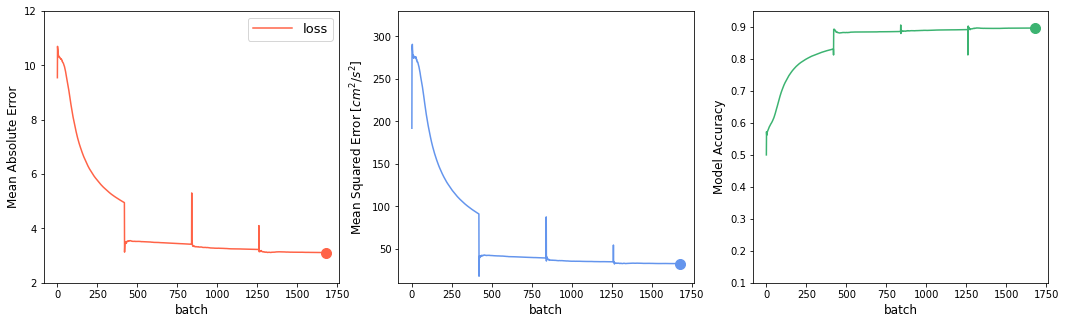

41967/41967 [==============================] - 288s 7ms/step - loss: 3.1131 - mae: 3.1131 - mse: 32.6139 - accuracy: 0.8967
INFO:tensorflow:Assets written to: models/SSHSST_2ps_pointXTAUXTAUY_3l_402010_nf80/assets


In [29]:
mnum = '04'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


In [30]:
%%time

inputs['05'], targets['05'] = prepare_data_2D(ds.isel(time=10), stencil_vars = ['SSH','X','Y','Z'], point_vars=['TAUX','TAUY',])
inputs['06'], targets['06'] = prepare_data_2D(ds.isel(time=10), stencil_vars = ['SSH','X',], point_vars=['TAUX','TAUY',])
inputs['07'], targets['07'] = prepare_data_2D(ds.isel(time=10), stencil_vars = ['SSH','SST','X','Y','Z',], point_vars=['TAUX','TAUY'])
inputs['08'], targets['08'] = prepare_data_2D(ds.isel(time=10), stencil_vars = ['SSH','SST','X'], point_vars=['TAUX','TAUY'])
inputs['09'], targets['09'] = prepare_data_2D(ds.isel(time=10), stencil_vars = ['SSH','TAUX','TAUY',], point_vars=['X',])
inputs['10'], targets['10'] = prepare_data_2D(ds.isel(time=10), stencil_vars = ['SSH','SST','TAUX','TAUY',], point_vars=['X'])
inputs['11'], targets['11'] = prepare_data_2D(ds.isel(time=10), stencil_vars = ['SSH','SST',], point_vars=['X','dx','dy','TAUX','TAUY'])

CPU times: user 16.4 s, sys: 4.74 s, total: 21.2 s
Wall time: 28.4 s


In [31]:
for r in ['05','06','07','08','09','10','11']:
    input_stencil[r] = keras.Input(shape=inputs[r][0].shape[1:])
    input_points[r] = keras.Input(shape=inputs[r][1].shape[1:])
    conv_layer[r] = tf.keras.layers.Conv2D(nfilters, 2)(input_stencil[r])
    reshape_layer[r] = tf.keras.layers.Reshape((nfilters,))(conv_layer[r])
    concat_layer[r] = tf.keras.layers.concatenate([reshape_layer[r], input_points[r]])
    combined_relu[r] = tf.keras.layers.LeakyReLU(alpha=0.3)(concat_layer[r])
    hidden_layer_1[r] = tf.keras.layers.Dense(40, activation='relu')(combined_relu[r])
    hidden_layer_2[r] = tf.keras.layers.Dense(20, activation='relu')(hidden_layer_1[r])
    hidden_layer_3[r] = tf.keras.layers.Dense(10, activation='relu')(hidden_layer_2[r])
    output_layer[r] = tf.keras.layers.Dense(2)(hidden_layer_3[r])

    model[r] = tf.keras.Model(inputs=[input_stencil[r], input_points[r]],
                        outputs=output_layer[r])

    # optimizer = tf.train.AdamOptimizer()
    model[r].compile(loss='mae', optimizer='Adam', metrics=['mae', 'mse','accuracy'])
    model[r].summary()

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 2, 2, 4)]    0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 1, 1, 80)     1360        input_49[0][0]                   
__________________________________________________________________________________________________
reshape_24 (Reshape)            (None, 80)           0           conv2d_24[0][0]                  
__________________________________________________________________________________________________
input_50 (InputLayer)           [(None, 2)]          0                                            
___________________________________________________________________________________________

In [32]:
labels['05'] = 'SSHXYZ_2ps_pointTAUXTAUY_3l_402010_nf80'
labels['06'] = 'SSHX_2ps_pointTAUXTAUY_3l_402010_nf80'
labels['07'] = 'SSHSSTXYZ_2ps_pointTAUXTAUY_3l_402010_nf80'
labels['08'] = 'SSHSSTX_2ps_pointTAUXTAUY_3l_402010_nf80'
labels['09'] = 'SSHTAUXTAUY_2ps_pointX_3l_402010_nf80'
labels['10'] = 'SSHSSTTAUXTAUY_2ps_pointX_3l_402010_nf80'
labels['11'] = 'SSHSST_2ps_pointXdxdyTAUXTAUY_3l_402010_nf80'

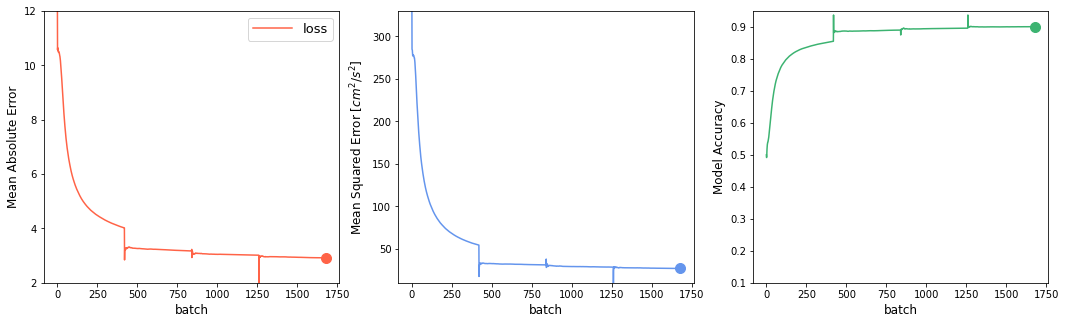

41967/41967 [==============================] - 290s 7ms/step - loss: 2.9187 - mae: 2.9187 - mse: 26.8495 - accuracy: 0.9010
INFO:tensorflow:Assets written to: models/SSHXYZ_2ps_pointTAUXTAUY_3l_402010_nf80/assets


In [33]:
mnum = '05'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


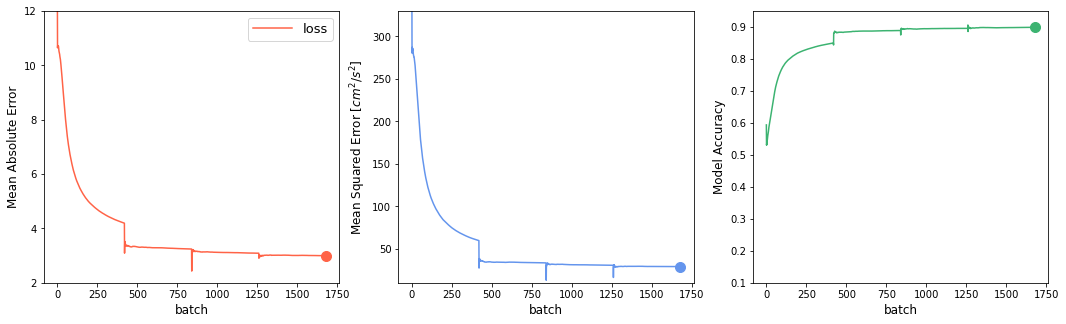

41967/41967 [==============================] - 293s 7ms/step - loss: 2.9980 - mae: 2.9980 - mse: 29.0903 - accuracy: 0.8990
INFO:tensorflow:Assets written to: models/SSHX_2ps_pointTAUXTAUY_3l_402010_nf80/assets


In [34]:
mnum = '06'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


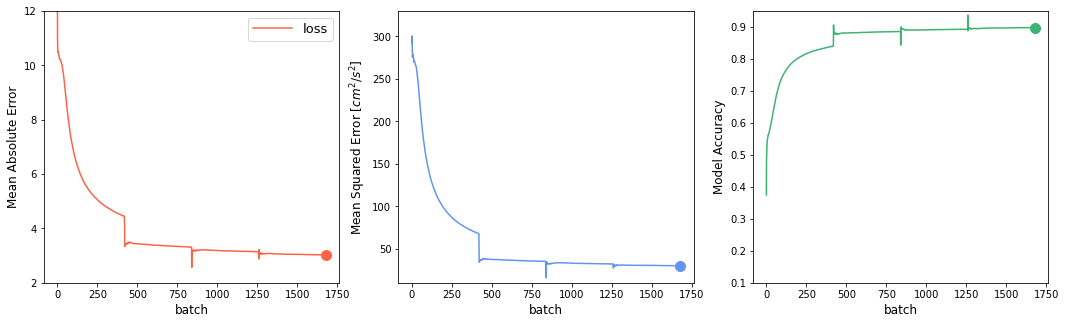

41967/41967 [==============================] - 305s 7ms/step - loss: 3.0238 - mae: 3.0238 - mse: 30.1030 - accuracy: 0.8980
INFO:tensorflow:Assets written to: models/SSHSSTXYZ_2ps_pointTAUXTAUY_3l_402010_nf80/assets


In [35]:
mnum = '07'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


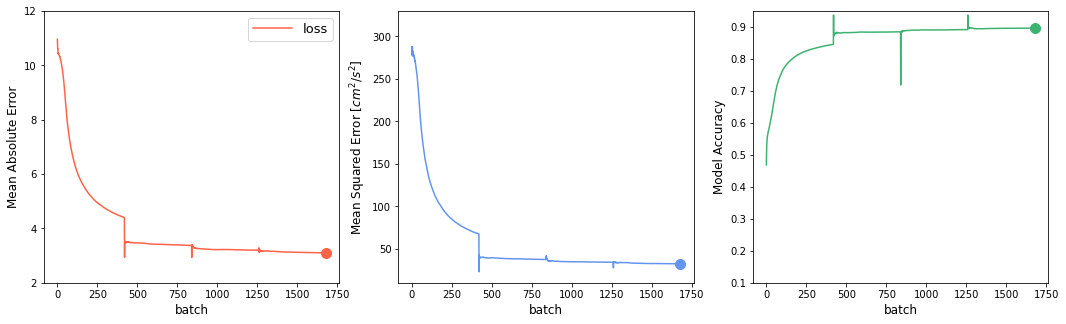

41967/41967 [==============================] - 283s 7ms/step - loss: 3.0993 - mae: 3.0993 - mse: 32.2886 - accuracy: 0.8965
INFO:tensorflow:Assets written to: models/SSHSSTX_2ps_pointTAUXTAUY_3l_402010_nf80/assets


In [36]:
mnum = '08'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


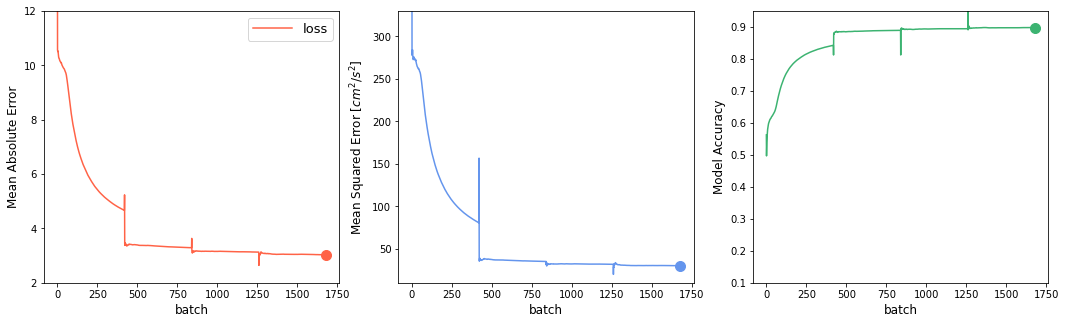

41967/41967 [==============================] - 282s 7ms/step - loss: 3.0299 - mae: 3.0299 - mse: 30.0929 - accuracy: 0.8983
INFO:tensorflow:Assets written to: models/SSHTAUXTAUY_2ps_pointX_3l_402010_nf80/assets


In [37]:
mnum = '09'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


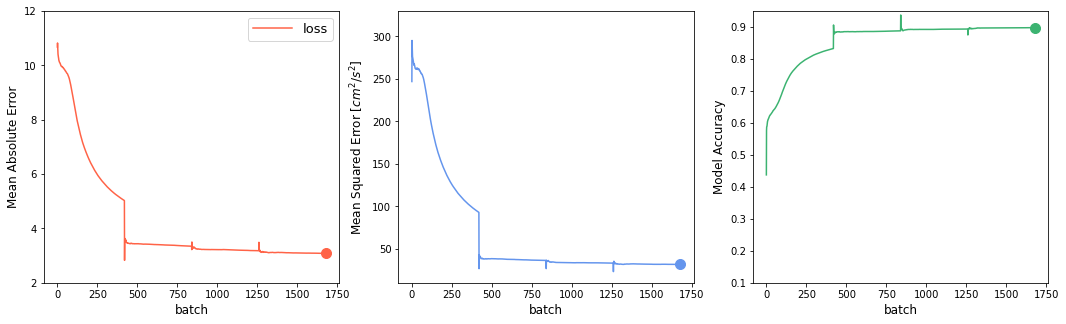

41967/41967 [==============================] - 282s 7ms/step - loss: 3.0826 - mae: 3.0826 - mse: 31.5855 - accuracy: 0.8978
INFO:tensorflow:Assets written to: models/SSHSSTTAUXTAUY_2ps_pointX_3l_402010_nf80/assets


In [38]:
mnum = '10'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


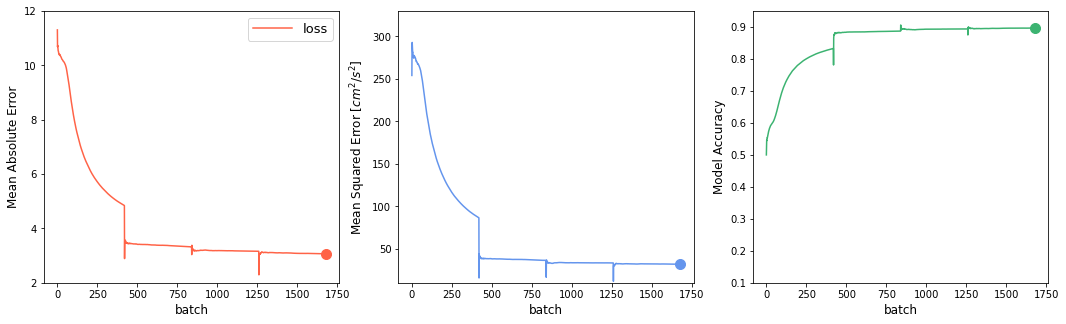

41967/41967 [==============================] - 280s 7ms/step - loss: 3.0659 - mae: 3.0659 - mse: 31.8739 - accuracy: 0.8969
INFO:tensorflow:Assets written to: models/SSHSST_2ps_pointXdxdyTAUXTAUY_3l_402010_nf80/assets


In [39]:
mnum = '11'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


In [41]:
labels['12'] = 'SSHSSTSSS_2ps_pointXdxdyTAUXTAUY_3l_402010_nf80'
inputs['12'], targets['12'] = prepare_data_2D(ds.isel(time=10), stencil_vars = ['SSH','SST','SSS',], point_vars=['X','dx','dy','TAUX','TAUY'])

In [42]:
for r in ['12']:
    input_stencil[r] = keras.Input(shape=inputs[r][0].shape[1:])
    input_points[r] = keras.Input(shape=inputs[r][1].shape[1:])
    conv_layer[r] = tf.keras.layers.Conv2D(nfilters, 2)(input_stencil[r])
    reshape_layer[r] = tf.keras.layers.Reshape((nfilters,))(conv_layer[r])
    concat_layer[r] = tf.keras.layers.concatenate([reshape_layer[r], input_points[r]])
    combined_relu[r] = tf.keras.layers.LeakyReLU(alpha=0.3)(concat_layer[r])
    hidden_layer_1[r] = tf.keras.layers.Dense(40, activation='relu')(combined_relu[r])
    hidden_layer_2[r] = tf.keras.layers.Dense(20, activation='relu')(hidden_layer_1[r])
    hidden_layer_3[r] = tf.keras.layers.Dense(10, activation='relu')(hidden_layer_2[r])
    output_layer[r] = tf.keras.layers.Dense(2)(hidden_layer_3[r])

    model[r] = tf.keras.Model(inputs=[input_stencil[r], input_points[r]],
                        outputs=output_layer[r])

    # optimizer = tf.train.AdamOptimizer()
    model[r].compile(loss='mae', optimizer='Adam', metrics=['mae', 'mse','accuracy'])
    model[r].summary()

Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_63 (InputLayer)           [(None, 2, 2, 3)]    0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 1, 1, 80)     1040        input_63[0][0]                   
__________________________________________________________________________________________________
reshape_31 (Reshape)            (None, 80)           0           conv2d_31[0][0]                  
__________________________________________________________________________________________________
input_64 (InputLayer)           [(None, 5)]          0                                            
___________________________________________________________________________________________

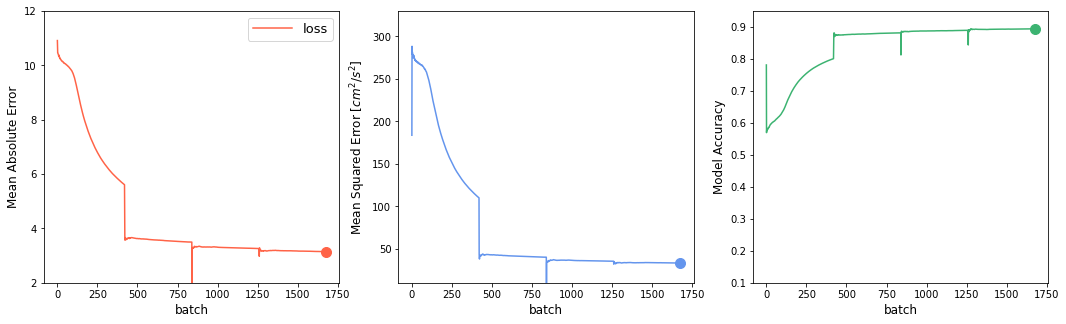

41676/41967 [============================>.] - ETA: 2s - loss: 3.1437 - mae: 3.1437 - mse: 33.2628 - accuracy: 0.8942

In [ ]:
mnum = '12'

history[mnum] = LossHistory()
model[mnum].fit(inputs[mnum], targets[mnum], batch_size=32, epochs=4,callbacks=[history[mnum]])

model[mnum].save('models/'+ labels[mnum])
np.savez('models/history_' + labels[mnum], losses = history[mnum].losses, mse = history[mnum].mse, accuracy = history[mnum].accuracy)


In [ ]:
caplabels = {}
caplabels

<ipython-input-48-e398f31c2dce>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(131)
<ipython-input-48-e398f31c2dce>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(132)
<ipython-input-48-e398f31c2dce>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returne

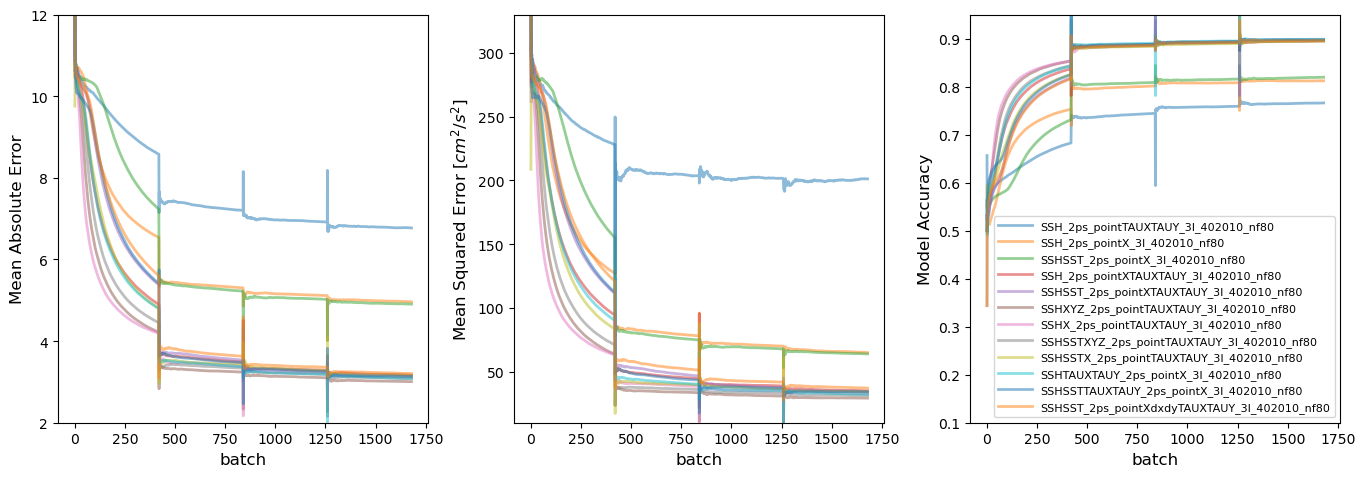

In [48]:
plt.figure(figsize=(14,5), tight_layout=True, dpi=100)
for r in history.keys():
    plt.subplot(131)
    plt.plot(history[r].losses, alpha=0.5, linewidth=2, label = labels[r])
    plt.xlabel(r'batch');
    plt.ylabel('Mean Absolute Error');
    plt.ylim([2,12])
    plt.grid()
#     plt.legend()
    
    plt.subplot(132)
    plt.plot(history[r].mse, alpha=0.5, linewidth=2, label = labels[r])
    plt.xlabel('batch');
    plt.ylabel(r'Mean Squared Error [$cm^2/s^2$]');
    plt.ylim([10,330])
    plt.grid(axis='both')
#     plt.legend()

    plt.subplot(133)
    plt.plot(history[r].accuracy, alpha=0.5, linewidth=2, label = labels[r])
    plt.xlabel('batch');
    plt.ylabel('Model Accuracy');
    plt.ylim([0.1,0.95])
    plt.grid()
    plt.legend(fontsize=8)


In [59]:
labels

{'00': 'SSH_2ps_pointTAUXTAUY_3l_402010_nf80',
 '01': 'SSH_2ps_pointX_3l_402010_nf80',
 '02': 'SSHSST_2ps_pointX_3l_402010_nf80',
 '03': 'SSH_2ps_pointXTAUXTAUY_3l_402010_nf80',
 '04': 'SSHSST_2ps_pointXTAUXTAUY_3l_402010_nf80',
 '05': 'SSHXYZ_2ps_pointTAUXTAUY_3l_402010_nf80',
 '06': 'SSHX_2ps_pointTAUXTAUY_3l_402010_nf80',
 '07': 'SSHSSTXYZ_2ps_pointTAUXTAUY_3l_402010_nf80',
 '08': 'SSHSSTX_2ps_pointTAUXTAUY_3l_402010_nf80',
 '09': 'SSHTAUXTAUY_2ps_pointX_3l_402010_nf80',
 '10': 'SSHSSTTAUXTAUY_2ps_pointX_3l_402010_nf80',
 '11': 'SSHSST_2ps_pointXdxdyTAUXTAUY_3l_402010_nf80'}

In [51]:
features_pred = {}
targets_true = {}
targets_pred = {}

In [52]:
%%time

features_pred['00'], targets_true['00'] = prepare_data_2D(ds.isel(time=365*10+70), stencil_vars = ['SSH',], point_vars=['TAUX','TAUY',],
                                                          apply_mask=False, randomize=False,)
features_pred['01'], targets_true['01'] = prepare_data_2D(ds.isel(time=365*10+70), stencil_vars = ['SSH',], point_vars=['X',],
                                                          apply_mask=False, randomize=False,)
features_pred['02'], targets_true['02'] = prepare_data_2D(ds.isel(time=365*10+70), stencil_vars = ['SSH','SST',], point_vars=['X',],
                                                          apply_mask=False, randomize=False,)
features_pred['03'], targets_true['03'] = prepare_data_2D(ds.isel(time=365*10+70), stencil_vars = ['SSH',], point_vars=['X','TAUX','TAUY',],
                                                          apply_mask=False, randomize=False,)
features_pred['04'], targets_true['04'] = prepare_data_2D(ds.isel(time=365*10+70), stencil_vars = ['SSH','SST',], point_vars=['X','TAUX','TAUY'],
                                                          apply_mask=False, randomize=False,)
features_pred['05'], targets_true['05'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','X','Y','Z'], point_vars=['TAUX','TAUY',],
                                                          apply_mask=False, randomize=False,)
features_pred['06'], targets_true['06'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','X',], point_vars=['TAUX','TAUY',],
                                                          apply_mask=False, randomize=False,)
features_pred['07'], targets_true['07'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','SST','X','Y','Z',], point_vars=['TAUX','TAUY'],
                                                          apply_mask=False, randomize=False,)
features_pred['08'], targets_true['08'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','SST','X'], point_vars=['TAUX','TAUY'],
                                                          apply_mask=False, randomize=False,)
features_pred['09'], targets_true['09'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','TAUX','TAUY',], point_vars=['X',],
                                                          apply_mask=False, randomize=False,)
features_pred['10'], targets_true['10'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','SST','TAUX','TAUY',], point_vars=['X'],
                                                          apply_mask=False, randomize=False,)
features_pred['11'], targets_true['11'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','SST',], point_vars=['X','dx','dy','TAUX','TAUY'],
                                                          apply_mask=False, randomize=False,)

CPU times: user 19.8 s, sys: 10.8 s, total: 30.6 s
Wall time: 43.8 s


In [54]:
from timeit import default_timer as timer

In [55]:
for mnum in model.keys():
    start = timer()
    targets_pred[mnum] = model[mnum].predict(features_pred[mnum])
    end = timer()
    print(mnum, end - start)

00 70.77923383901361
01 70.73899236496072
02 69.83579571399605
03 72.53077975899214
04 70.95082871802151
05 70.57126859598793
06 70.02143764396897
07 71.01272665400757
08 70.81430834002094
09 72.63865095400251
10 69.51252712198766
11 71.29093616496539


In [56]:
%%time

features_test = {}
targets_test = {}

features_test['00'], targets_test['00'] = prepare_data_2D(ds.isel(time=365*10+70), stencil_vars = ['SSH',], point_vars=['TAUX','TAUY',],
                                                          apply_mask=True, randomize=False,)
features_test['01'], targets_test['01'] = prepare_data_2D(ds.isel(time=365*10+70), stencil_vars = ['SSH',], point_vars=['X',],
                                                          apply_mask=True, randomize=False,)
features_test['02'], targets_test['02'] = prepare_data_2D(ds.isel(time=365*10+70), stencil_vars = ['SSH','SST',], point_vars=['X',],
                                                          apply_mask=True, randomize=False,)
features_test['03'], targets_test['03'] = prepare_data_2D(ds.isel(time=365*10+70), stencil_vars = ['SSH',], point_vars=['X','TAUX','TAUY',],
                                                          apply_mask=True, randomize=False,)
features_test['04'], targets_test['04'] = prepare_data_2D(ds.isel(time=365*10+70), stencil_vars = ['SSH','SST',], point_vars=['X','TAUX','TAUY'],
                                                          apply_mask=True, randomize=False,)
features_test['05'], targets_test['05'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','X','Y','Z'], point_vars=['TAUX','TAUY',],
                                                          apply_mask=True, randomize=False,)
features_test['06'], targets_test['06'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','X',], point_vars=['TAUX','TAUY',],
                                                          apply_mask=True, randomize=False,)
features_test['07'], targets_test['07'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','SST','X','Y','Z',], point_vars=['TAUX','TAUY'],
                                                          apply_mask=True, randomize=False,)
features_test['08'], targets_test['08'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','SST','X'], point_vars=['TAUX','TAUY'],
                                                          apply_mask=True, randomize=False,)
features_test['09'], targets_test['09'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','TAUX','TAUY',], point_vars=['X',],
                                                          apply_mask=True, randomize=False,)
features_test['10'], targets_test['10'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','SST','TAUX','TAUY',], point_vars=['X'],
                                                          apply_mask=True, randomize=False,)
features_test['11'], targets_test['11'] = prepare_data_2D(ds.isel(time=365*10+70), 
                                                          stencil_vars = ['SSH','SST',], point_vars=['X','dx','dy','TAUX','TAUY'],
                                                          apply_mask=True, randomize=False,)


CPU times: user 18.4 s, sys: 9.63 s, total: 28 s
Wall time: 33 s


In [57]:
for mnum in model.keys():
    model[mnum].evaluate(features_test[mnum], targets_test[mnum])


41967/41967 [==============================] - 81s 2ms/step - loss: 4.0232 - mae: 4.0232 - mse: 46.0133 - accuracy: 0.9123


In [61]:
mae = np.array([7.7946, 5.1257, 5.1260, 3.1067, 3.2977, 3.0840, 3.2387, 3.3040, 3.7069, 3.6339, 3.2265, 4.0232])
mse = np.array([233.0203, 63.3984, 65.9020, 39.5688, 36.4640, 34.4702, 39.0651, 37.6900, 41.3248, 40.4397, 36.7599, 46.0133 ])
acc = np.array([0.6970, 0.7765, 0.7963, 0.9063, 0.8699, 0.8924, 0.9052, 0.8779, 0.8557, 0.8388, 0.8937, 0.9123 ])
loss_ev = {}
mse_ev = {}
acc_ev = {}
for i,r in enumerate(model.keys()):
    loss_ev[r] = mae[i]
    mse_ev[r] = mse[i]
    acc_ev[r] = acc[i]


In [63]:
colors = {'00': 'rosybrown', 
          '01' : 'royalblue', 
          '02' : 'mediumblue', 
          '03' : 'midnightblue', 
          '04' : 'slateblue', 
          '05' : 'mediumorchid', 
          '06': 'violet', 
          '07' : 'mediumvioletred', 
          '08' : 'crimson', 
          '09' : 'firebrick', 
          '10' : 'coral', 
          '11' : 'chocolate'
         }


<ipython-input-66-35b7581742d5>:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(331)
<ipython-input-66-35b7581742d5>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(332)
<ipython-input-66-35b7581742d5>:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returne

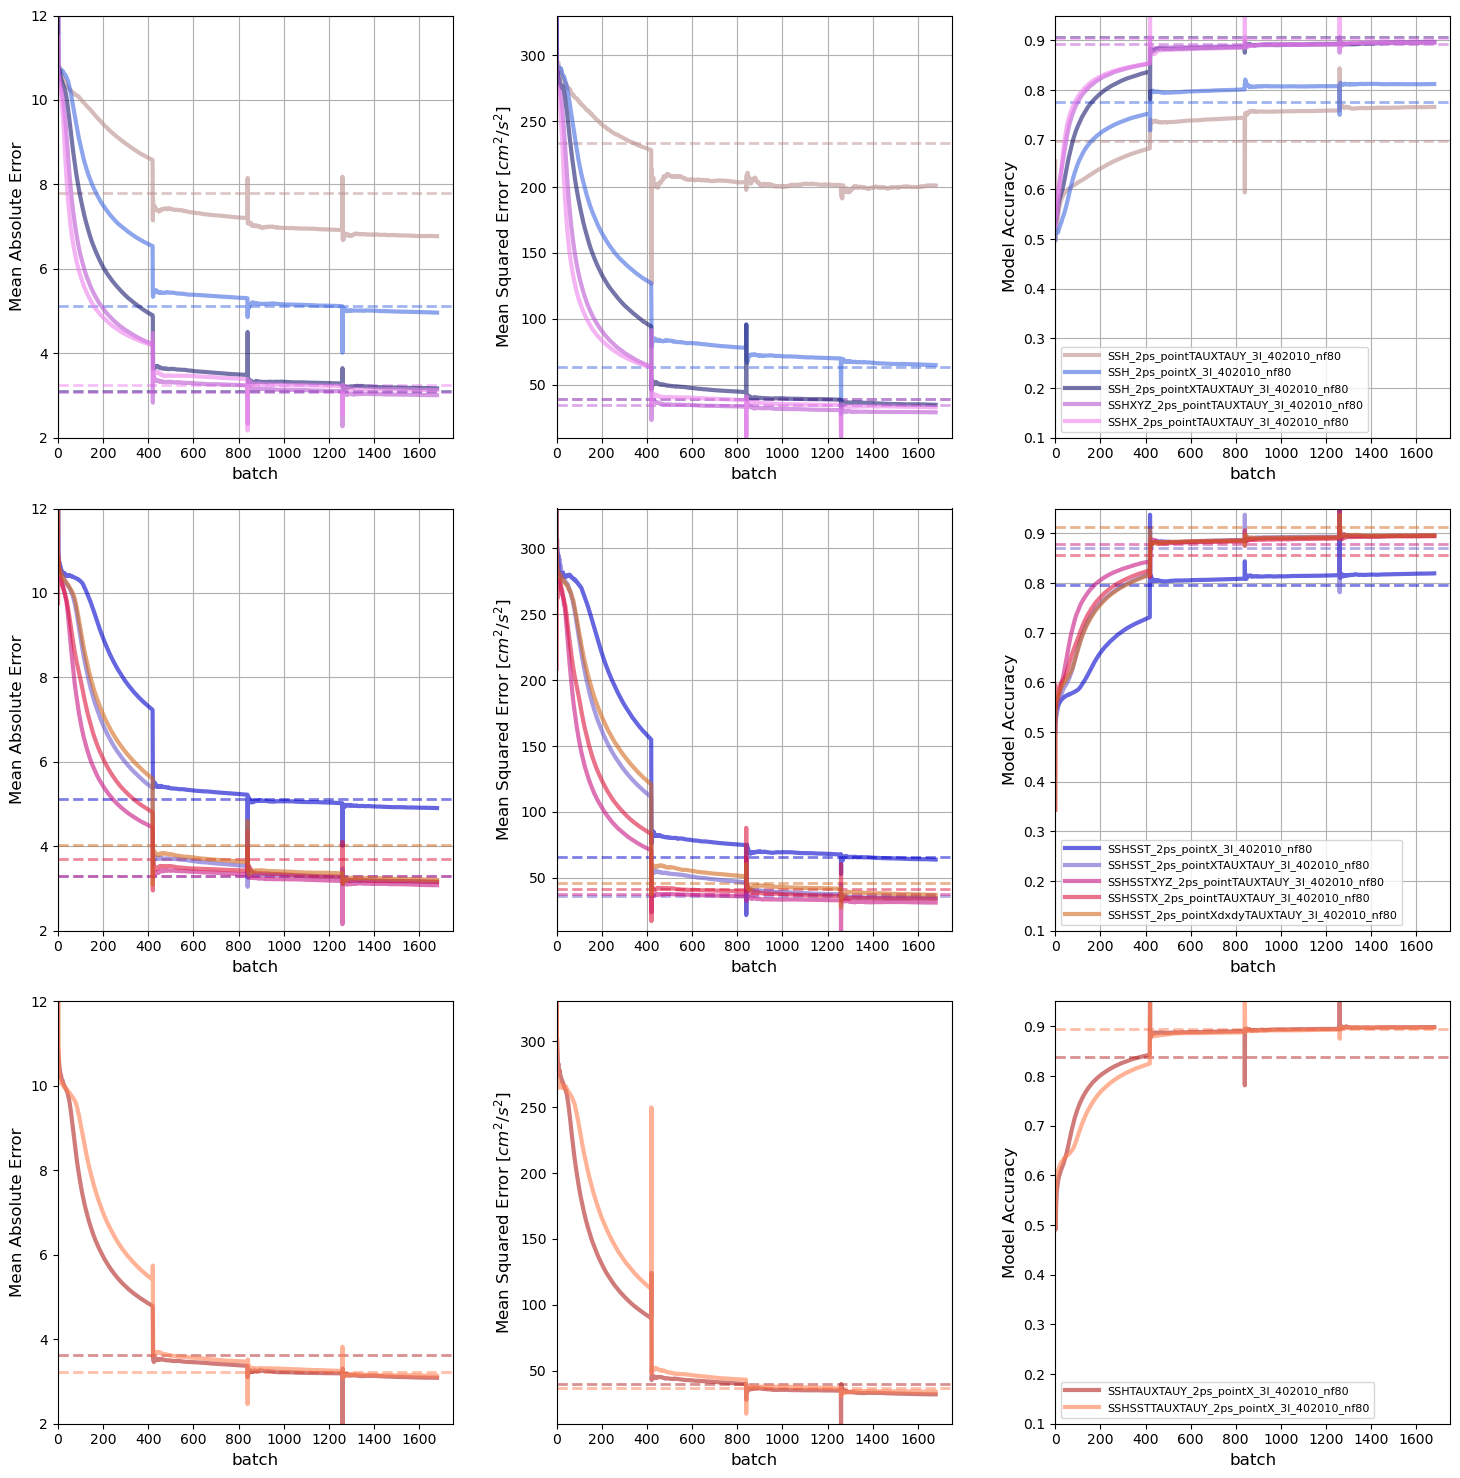

In [66]:
plt.figure(figsize=(15,15), tight_layout=True, dpi=100)
for r in ['00','01','03','05','06']:
    plt.subplot(331)
    plt.plot(history[r].losses, alpha=0.6, linewidth=3, label = labels[r], color= colors[r])
    plt.hlines(loss_ev[r], xmin=0, xmax=1750, linewidth = 2, linestyle='dashed', alpha=0.5, color= colors[r])
    plt.xlabel(r'batch');
    plt.ylabel('Mean Absolute Error');
    plt.xlim([0,1750])
    plt.ylim([2,12])
    plt.grid()
#     plt.legend()
    
    plt.subplot(332)
    plt.plot(history[r].mse, alpha=0.6, linewidth=3, label = labels[r], color= colors[r])
    plt.hlines(mse_ev[r], xmin=0, xmax=1750, linewidth = 2, linestyle='dashed', alpha=0.5, color= colors[r])
    plt.xlabel('batch');
    plt.ylabel(r'Mean Squared Error [$cm^2/s^2$]');
    plt.xlim([0,1750])
    plt.ylim([10,330])
    plt.grid(axis='both')
#     plt.legend()

    plt.subplot(333)
    plt.plot(history[r].accuracy, alpha=0.6, linewidth=3, label = labels[r], color= colors[r])
    plt.hlines(acc_ev[r], xmin=0, xmax=1750, linewidth = 2, linestyle='dashed', alpha=0.5, color= colors[r])
    plt.xlabel('batch');
    plt.ylabel('Model Accuracy');
    plt.xlim([0,1750])
    plt.ylim([0.1,0.95])
    plt.grid()
    plt.legend(fontsize=8)

for r in ['02','04','07','08','11']:
    plt.subplot(334)
    plt.plot(history[r].losses, alpha=0.6, linewidth=3, label = labels[r], color= colors[r])
    plt.hlines(loss_ev[r], xmin=0, xmax=1750, linewidth = 2, linestyle='dashed', alpha=0.5, color= colors[r])
    plt.xlabel(r'batch');
    plt.ylabel('Mean Absolute Error');
    plt.xlim([0,1750])
    plt.ylim([2,12])
    plt.grid()
#     plt.legend()
    
    plt.subplot(335)
    plt.plot(history[r].mse, alpha=0.6, linewidth=3, label = labels[r], color= colors[r])
    plt.hlines(mse_ev[r], xmin=0, xmax=1750, linewidth = 2, linestyle='dashed', alpha=0.5, color= colors[r])
    plt.xlabel('batch');
    plt.ylabel(r'Mean Squared Error [$cm^2/s^2$]');
    plt.xlim([0,1750])
    plt.ylim([10,330])
    plt.grid(axis='both')
#     plt.legend()

    plt.subplot(336)
    plt.plot(history[r].accuracy, alpha=0.6, linewidth=3, label = labels[r], color= colors[r])
    plt.hlines(acc_ev[r], xmin=0, xmax=1750, linewidth = 2, linestyle='dashed', alpha=0.5, color= colors[r])
    plt.xlabel('batch');
    plt.ylabel('Model Accuracy');
    plt.xlim([0,1750])
    plt.ylim([0.1,0.95])
    plt.grid()
    plt.legend(fontsize=8)
    
for r in ['09','10']:
    plt.subplot(337)
    plt.plot(history[r].losses, alpha=0.6, linewidth=3, label = labels[r], color= colors[r])
    plt.hlines(loss_ev[r], xmin=0, xmax=1750, linewidth = 2, linestyle='dashed', alpha=0.5, color= colors[r])
    plt.xlabel(r'batch');
    plt.ylabel('Mean Absolute Error');
    plt.xlim([0,1750])
    plt.ylim([2,12])
    plt.grid()
#     plt.legend()
    
    plt.subplot(338)
    plt.plot(history[r].mse, alpha=0.6, linewidth=3, label = labels[r], color= colors[r])
    plt.hlines(mse_ev[r], xmin=0, xmax=1750, linewidth = 2, linestyle='dashed', alpha=0.5, color= colors[r])
    plt.xlabel('batch');
    plt.ylabel(r'Mean Squared Error [$cm^2/s^2$]');
    plt.xlim([0,1750])
    plt.ylim([10,330])
    plt.grid(axis='both')
#     plt.legend()

    plt.subplot(339)
    plt.plot(history[r].accuracy, alpha=0.6, linewidth=3, label = labels[r], color= colors[r])
    plt.hlines(acc_ev[r], xmin=0, xmax=1750, linewidth = 2, linestyle='dashed', alpha=0.5, color= colors[r])
    plt.xlabel('batch');
    plt.ylabel('Model Accuracy');
    plt.xlim([0,1750])
    plt.ylim([0.1,0.95])
    plt.legend(fontsize=8)
    plt.grid()


In [ ]:
# mae: 7.7946 - mse: 233.0203 - accuracy: 0.6970
# mae: 5.1257 - mse: 63.3984 - accuracy: 0.7765
# mae: 5.1260 - mse: 65.9020 - accuracy: 0.7963
# mae: 3.1067 - mse: 39.5688 - accuracy: 0.9063
# mae: 3.2977 - mse: 36.4640 - accuracy: 0.8699
# mae: 3.0840 - mse: 34.4702 - accuracy: 0.8924
# mae: 3.2387 - mse: 39.0651 - accuracy: 0.9052
# mae: 3.3040 - mse: 37.6900 - accuracy: 0.8779
# mae: 3.7069 - mse: 41.3248 - accuracy: 0.8557
# mae: 3.6339 - mse: 40.4397 - accuracy: 0.8388
# mae: 3.2265 - mse: 36.7599 - accuracy: 0.8937
# mae: 4.0232 - mse: 46.0133 - accuracy: 0.9123


In [1]:
labels['000'] = 'SSH_3pt2ps_pointXdxdyTAUXTAUY_3l_402010_nf80'
labels['001'] = 'SSHSST_3pt2ps_pointXdxdyTAUXTAUY_3l_402010_nf80'
labels['002'] = 'SSH_3pt2ps_pointXTAUXTAUY_3l_402010_nf80'
labels['003'] = 'SSHSST_3pt2ps_pointXTAUXTAUY_3l_402010_nf80'
labels['004'] = 'SSH_3pt2ps_pointXdxdy_3l_402010_nf80'
labels['005'] = 'SSHSST_3pt2ps_pointXdxdy_3l_402010_nf80'
labels['006'] = 'SSH_3pt2ps_pointX_3l_402010_nf80'
labels['007'] = 'SSHSST_3pt2ps_pointX_3l_402010_nf80'
labels['008'] = 'SSHSSTSSS_3pt2ps_pointXTAUXTAUY_3l_402010_nf80'
labels['009'] = 'SSHSSTSSS_3pt2ps_pointXdxdyTAUXTAUY_3l_402010_nf80'


NameError: name 'labels' is not defined

{'00': 'SSH_2ps_pointTAUXTAUY_3l_402010_nf80',
 '01': 'SSH_2ps_pointX_3l_402010_nf80',
 '02': 'SSHSST_2ps_pointX_3l_402010_nf80',
 '03': 'SSH_2ps_pointXTAUXTAUY_3l_402010_nf80',
 '04': 'SSHSST_2ps_pointXTAUXTAUY_3l_402010_nf80',
 '05': 'SSHXYZ_2ps_pointTAUXTAUY_3l_402010_nf80',
 '06': 'SSHX_2ps_pointTAUXTAUY_3l_402010_nf80',
 '07': 'SSHSSTXYZ_2ps_pointTAUXTAUY_3l_402010_nf80',
 '08': 'SSHSSTX_2ps_pointTAUXTAUY_3l_402010_nf80',
 '09': 'SSHTAUXTAUY_2ps_pointX_3l_402010_nf80',
 '10': 'SSHSSTTAUXTAUY_2ps_pointX_3l_402010_nf80',
 '11': 'SSHSST_2ps_pointXdxdyTAUXTAUY_3l_402010_nf80',
 '000': 'SSH_3pt2ps_pointXdxdyTAUXTAUY_3l_402010_nf80',
 '001': 'SSHSST_3pt2ps_pointXdxdyTAUXTAUY_3l_402010_nf80',
 '002': 'SSH_3pt2ps_pointXTAUXTAUY_3l_402010_nf80',
 '003': 'SSHSST_3pt2ps_pointXTAUXTAUY_3l_402010_nf80',
 '004': 'SSH_3pt2ps_pointXdxdy_3l_402010_nf80',
 '005': 'SSHSST_3pt2ps_pointXdxdy_3l_402010_nf80',
 '006': 'SSHSST_3pt2ps_pointX_3l_402010_nf80',
 '007': 'SSHSST_3pt2ps_pointX_3l_402010_nf80',


In [74]:
model2 = {}
history2 = {}
for r in ['000','001','002','003','004','005','006','007','008','009']:
    model2[r] = keras.models.load_model('models/' + labels[r])
    history2[r] = np.load('models/history_%s.npz' %labels[r])

In [86]:
model2['006'].summary()

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_69 (InputLayer)           [(None, 2, 2, 3, 2)] 0                                            
__________________________________________________________________________________________________
conv3d_25 (Conv3D)              (None, 1, 1, 1, 80)  2000        input_69[0][0]                   
__________________________________________________________________________________________________
reshape_25 (Reshape)            (None, 80)           0           conv3d_25[0][0]                  
__________________________________________________________________________________________________
input_70 (InputLayer)           [(None, 1)]          0                                            
___________________________________________________________________________________________

In [79]:
def reshape_stencil(data, ssize):
    assert data.ndim == 2
    ny, nx = data.shape
    data_rs = data.reshape((ny//ssize, ssize,  nx//ssize, ssize))
    # move stencil to end
    data_mv = np.moveaxis(data_rs, 1, 2)
    data_flat = data_mv.reshape((-1, 2, 2))
    return data_flat

def reshape_stencil_time(data, ssize):
    assert data.ndim == 3
    nt, ny, nx = data.shape
    data_rs = data.reshape((nt, ny//ssize, ssize,  nx//ssize, ssize))
    # move stencil to end
    data_mv = np.moveaxis(np.moveaxis(data_rs, 2, 3), 0,4)
    data_flat = data_mv.reshape((-1, 2, 2, 3))
    return data_flat

def extract_data_loc(ds, vname, stencil_size, indexer):
    data = ds[vname].values
    data_rs = reshape_stencil(data, stencil_size)
    data_idx = data_rs[(slice(None),) + indexer]
    return data_idx

def extract_data_time(ds, vname, stencil_size, indexer):
    data = ds[vname].values
    data_rs = reshape_stencil_time(data, stencil_size)
    data_idx = data_rs[(slice(None),) + indexer]
    return data_idx

def prepare_data_3dpointloc(ds, apply_mask=True, randomize=True, stencil_size = 2,
                            stencil_time_vars = ['SSH',], stencil_time_index = (slice(None), slice(None), slice(None)),
                            point_vars = ['TAUX', 'TAUY'], point_index = (1, 0, 0), 
                            loc_vars = ['X','dx','dy'], loc_index = (0, 0), 
                            target_vars = ['U', 'V'], target_index = (1, 0, 0) ):
    
    stencil_time_data = [extract_data_time(ds, vname, stencil_size, stencil_time_index)
                    for vname in stencil_time_vars]    
    loc_data = [extract_data_loc(ds, vname, stencil_size, loc_index)
                    for vname in loc_vars]
    point_data = [extract_data_time(ds, vname, stencil_size, point_index)
                   for vname in point_vars]
    target_data = [extract_data_time(ds, vname, stencil_size, target_index)
                   for vname in target_vars]

    if apply_mask:
        mask = np.isnan(stencil_time_data[0]).sum(axis=(1, 2, 3)) == 0
    else:
        mask = slice(None)
    if randomize:
        random_idx = np.random.permutation(mask.sum())
    else:
        random_idx = slice(None)

    features_stencil_time = np.stack([data[mask][random_idx] for data in stencil_time_data],
                                axis=-1)
    features_loc = np.stack([data[mask][random_idx] for data in loc_data],
                                axis=-1)
    
    features_point = np.stack([data[mask][random_idx] for data in point_data],
                               axis=-1)
    targets = np.stack([data[mask][random_idx] for data in target_data],
                        axis=-1)
    return [features_stencil_time, features_point, features_loc], targets


def prepare_data_3dloc(ds, apply_mask=True, randomize=True, stencil_size = 2,
                            stencil_time_vars = ['SSH',], stencil_time_index = (slice(None), slice(None), slice(None)),
                            loc_vars = ['X','dx','dy'], loc_index = (0, 0), 
                            target_vars = ['U', 'V'], target_index = (1, 0, 0) ):
    
    stencil_time_data = [extract_data_time(ds, vname, stencil_size, stencil_time_index)
                    for vname in stencil_time_vars]    
    loc_data = [extract_data_loc(ds, vname, stencil_size, loc_index)
                    for vname in loc_vars]
    target_data = [extract_data_time(ds, vname, stencil_size, target_index)
                   for vname in target_vars]

    if apply_mask:
        mask = np.isnan(stencil_time_data[0]).sum(axis=(1, 2, 3)) == 0
    else:
        mask = slice(None)
    if randomize:
        random_idx = np.random.permutation(mask.sum())
    else:
        random_idx = slice(None)

    features_stencil_time = np.stack([data[mask][random_idx] for data in stencil_time_data],
                                axis=-1)
    features_loc = np.stack([data[mask][random_idx] for data in loc_data],
                                axis=-1)
    targets = np.stack([data[mask][random_idx] for data in target_data],
                        axis=-1)
    return [features_stencil_time, features_loc], targets


In [81]:
%%time

features_pred['000'], targets_true['000'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH',], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X','dx','dy'], apply_mask=False, randomize=False,)
features_pred['001'], targets_true['001'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH','SST',], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X','dx','dy'], apply_mask=False, randomize=False,)
features_pred['002'], targets_true['002'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH',], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X'], apply_mask=False, randomize=False,)
features_pred['003'], targets_true['003'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH', 'SST'], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X'], apply_mask=False, randomize=False,)
features_pred['004'], targets_true['004'] = prepare_data_3dloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH',], 
                                                        loc_vars = ['X','dx','dy'], apply_mask=False, randomize=False,)
features_pred['005'], targets_true['005'] = prepare_data_3dloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH','SST'], 
                                                        loc_vars = ['X','dx','dy'], apply_mask=False, randomize=False,)
features_pred['006'], targets_true['006'] = prepare_data_3dloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH',], 
                                                        loc_vars = ['X',], apply_mask=False, randomize=False,)
features_pred['007'], targets_true['007'] = prepare_data_3dloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH','SST',], 
                                                        loc_vars = ['X',], apply_mask=False, randomize=False,)
features_pred['008'], targets_true['008'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH', 'SST', 'SSS',], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X'], apply_mask=False, randomize=False,)
features_pred['009'], targets_true['009'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH', 'SST', 'SSS'], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X', 'dx', 'dy'], apply_mask=False, randomize=False,)


CPU times: user 29.3 s, sys: 11.4 s, total: 40.8 s
Wall time: 44.6 s


In [82]:

features_test['000'], targets_test['000'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH',], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X','dx','dy'], apply_mask=True, randomize=False,)
features_test['001'], targets_test['001'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH','SST',], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X','dx','dy'], apply_mask=True, randomize=False,)
features_test['002'], targets_test['002'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH',], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X'], apply_mask=True, randomize=False,)
features_test['003'], targets_test['003'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH', 'SST'], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X'], apply_mask=True, randomize=False,)
features_test['004'], targets_test['004'] = prepare_data_3dloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH',], 
                                                        loc_vars = ['X','dx','dy'], apply_mask=True, randomize=False,)
features_test['005'], targets_test['005'] = prepare_data_3dloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH','SST'], 
                                                        loc_vars = ['X','dx','dy'], apply_mask=True, randomize=False,)
features_test['006'], targets_test['006'] = prepare_data_3dloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH',], 
                                                        loc_vars = ['X',], apply_mask=True, randomize=False,)
features_test['007'], targets_test['007'] = prepare_data_3dloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH','SST',], 
                                                        loc_vars = ['X',], apply_mask=False, randomize=False,)

features_test['008'], targets_test['008'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH', 'SST', 'SSS',], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X'], apply_mask=True, randomize=False,)
features_test['009'], targets_test['009'] = prepare_data_3dpointloc(ds.isel(time=slice(365*10+70, 365*10+73)),
                                                        stencil_time_vars = ['SSH', 'SST', 'SSS'], 
                                                        point_vars=['TAUX','TAUY',], 
                                                        loc_vars = ['X', 'dx', 'dy'], apply_mask=True, randomize=False,)



In [83]:
model2.keys()

dict_keys(['000', '001', '002', '003', '004', '005', '006', '007', '008', '009'])

In [84]:
for mnum in model2.keys():
    model2[mnum].evaluate(features_test[mnum], targets_test[mnum])


41967/41967 [==============================] - 52s 1ms/step - loss: 5.6873 - mean_absolute_error: 5.6873 - mean_squared_error: 77.8924 - accuracy: 0.7935


ValueError: in user code:

    /srv/conda/envs/notebook/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:941 test_function  *
        outputs = self.distribute_strategy.run(
    /srv/conda/envs/notebook/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /srv/conda/envs/notebook/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /srv/conda/envs/notebook/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /srv/conda/envs/notebook/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:909 test_step  **
        y_pred = self(x, training=False)
    /srv/conda/envs/notebook/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /srv/conda/envs/notebook/lib/python3.8/site-packages/tensorflow/python/keras/engine/network.py:717 call
        return self._run_internal_graph(
    /srv/conda/envs/notebook/lib/python3.8/site-packages/tensorflow/python/keras/engine/network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /srv/conda/envs/notebook/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:885 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /srv/conda/envs/notebook/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer conv3d_25 is incompatible with the layer: expected axis -1 of input shape to have value 2 but received input with shape [None, 2, 2, 3, 1]


In [ ]:
## Fill these in
# mae2 = np.array([7.7946, 5.1257, 5.1260, 3.1067, 3.2977, 3.0840, 3.2387, 3.3040, 3.7069, 3.6339, 3.2265, 4.0232])
# mse2 = np.array([233.0203, 63.3984, 65.9020, 39.5688, 36.4640, 34.4702, 39.0651, 37.6900, 41.3248, 40.4397, 36.7599, 46.0133 ])
# acc2 = np.array([0.6970, 0.7765, 0.7963, 0.9063, 0.8699, 0.8924, 0.9052, 0.8779, 0.8557, 0.8388, 0.8937, 0.9123 ])
# loss_ev = {}
# mse_ev = {}
# acc_ev = {}
for j,r in enumerate(model2.keys()):
    loss_ev[r] = mae2[j]
    mse_ev[r] = mse2[j]
    acc_ev[r] = acc2[j]


In [ ]:
colours = {'000': 'forestgreen', 
          '001' : 'darkgreen', 
          '002' : 'teal', 
          '003' : 'aqua', 
          '004' : 'springgreen', 
          '005' : 'mediumaquamarine', 
          '006': 'darkturquoise', 
          '007' : 'deepskyblue', 
          '008' : 'steelblue', 
          '009' : 'dodgerblue', 
         }


In [58]:
def unstack(data_flat, original_shape, stencil_size, target_index=(0, 0)):
    sub_shape = tuple(np.asarray(original_shape) // stencil_size)
    return data_flat.reshape(sub_shape)

In [ ]:
%%time

rms_err_zonmean = {}
rms_vel_zonmean = {}
rel_rmse_zonmean = {}
U_true = {}
V_true = {}
U_pred = {}
V_pred = {}
U_err = {}
V_err = {}
u_true_flat = {}
v_true_flat = {}
u_pred_flat = {}
v_pred_flat = {}

for mnum in model.keys():
    rms_err_zonmean[mnum] = np.nanmean(np.sqrt(unstack(np.sum((targets_true[mnum] - targets_pred[mnum])**2, axis=1), 
                                                       ds.U.shape[1:], 2)),axis=1)
    rms_vel_zonmean[mnum] = np.nanmean(np.sqrt(unstack(np.sum((targets_true[mnum])**2, axis=1), 
                                                       ds.U.shape[1:], 2)),axis=1)
    rel_rmse_zonmean[mnum] = np.nanmean(np.sqrt(unstack(np.sum((targets_true[mnum] - targets_pred[mnum])**2, axis=1), ds.U.shape[1:], 2) / 
                                                unstack(np.sum((targets_true[mnum])**2, axis=1),ds.U.shape[1:], 2)
                                               ),
                                        axis=1)

    U_true[mnum] = unstack(targets_true[mnum][:, 0], ds.U.shape[1:], 2)
    V_true[mnum] = unstack(targets_true[mnum][:, 1], ds.U.shape[1:], 2)
    U_pred[mnum] = unstack(targets_pred[mnum][:, 0], ds.U.shape[1:], 2)
    V_pred[mnum] = unstack(targets_pred[mnum][:, 1], ds.U.shape[1:], 2)
    U_err[mnum] = U_true[mnum] - U_pred[mnum]
    V_err[mnum] = V_true[mnum] - V_pred[mnum]
    u_true_flat[mnum], u_pred_flat[mnum], v_true_flat[mnum], v_pred_flat[mnum] = [np.ma.masked_invalid(data).ravel() 
                                                                                  for data in (U_true[mnum], U_pred[mnum], V_true[mnum], V_pred[mnum])]